In [122]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from DBLR_cal import BLRc
from IPython.display import Image
from IPython.core.display import HTML 
import fit_library as fit
%matplotlib nbagg

# Definitions and Data

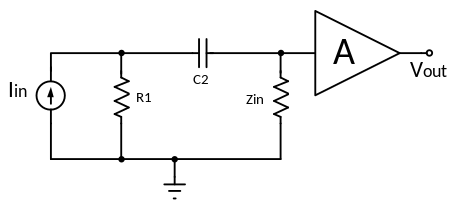

In [123]:
PATH = "./Rpar_Images/"
Image(filename = PATH + "FEE_simple.png")

In [124]:
f_sample = (1/25E-9); # Hz
ADC_GAIN_FACTOR=1.25

R1=1567; 
Zin=62; 
C2=16E-9; 
MEASURED_GAIN = 582.237

A=(MEASURED_GAIN/(R1*Zin/(R1+Zin)))*1.003991; print ("A= ",A)
#Butterworth Design Gain Factor
GAIN=(R1*Zin/(R1+Zin))*A 
# Seems stupid. It's just to remember true GAIN measured in simulation 

LSB=(2.0/4096)/ADC_GAIN_FACTOR; print "LSB = ",LSB
# Remember the ADC GAIN FACTOR = 1.25
SPE = 20

freq_HPF=1/((R1+Zin)*C2); print 'HPF1(kHz) =',freq_HPF/(1E3*2*np.pi)
freq_LPF1=3E6*2*np.pi; print 'LPF1(MHz) =',freq_LPF1/(1E6*2*np.pi)
freq_LPF2=10E6*2*np.pi; print 'LPF2(MHz) =',freq_LPF2/(1E6*2*np.pi)

freq_HPFd=freq_HPF / (f_sample*np.pi) ; print 'HPF(rad/sec) =',freq_HPF,'// (half-cycles/sample) =',freq_HPFd
freq_LPF1d=freq_LPF1 / (f_sample*np.pi) ; print 'LPF1(rad/sec) =',freq_LPF1,'// (half-cycles/sample) =',freq_LPF1d 
freq_LPF2d=freq_LPF2 / (f_sample*np.pi) ; print 'LPF2(rad/sec) =',freq_LPF2,'// (half-cycles/sample) =',freq_LPF2d



('A= ', 9.907808607915255)
LSB =  0.000390625
HPF1(kHz) = 6.10631304067
LPF1(MHz) = 3.0
LPF2(MHz) = 10.0
HPF(rad/sec) = 38367.0963781 // (half-cycles/sample) = 0.000305315652033
LPF1(rad/sec) = 18849555.9215 // (half-cycles/sample) = 0.15
LPF2(rad/sec) = 62831853.0718 // (half-cycles/sample) = 0.5


# ======  FEE MODEL ======

In [125]:
b0, a0 = signal.butter(1, freq_HPFd, 'high', analog=False)
b1, a1 = signal.butter(1, freq_LPF1d, 'low', analog=False); b2, a2 = signal.butter(4, freq_LPF2d, 'low', analog=False);
a_LPF=np.convolve(a1,a2,mode='full'); a=np.convolve(a_LPF,a0,mode='full')
b_LPF=np.convolve(b1,b2,mode='full'); b_aux2=np.convolve(b_LPF,b0,mode='full'); b=GAIN*b_aux2

<IPython.core.display.Javascript object>


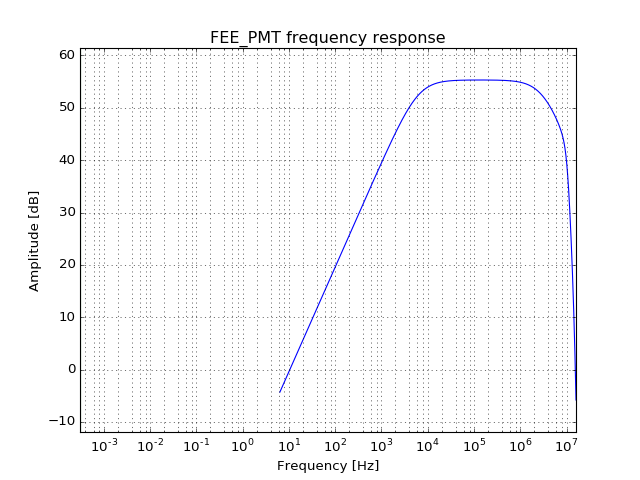

In [126]:
w, h = signal.freqz(b, a, worN=np.logspace(-6,0.4,40000))                # Freqz outputs rad/sample (desnorm ===> f_sample/(2*pi))
plt.figure(2)
plt.semilogx(w*(f_sample)/(2*np.pi), 20 * np.log10(abs(h)))
plt.title('FEE_PMT frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(freq_HPFd, color='green') # cutoff frequency
plt.show()

# ====== TEST ADDING NOISE  ======

In [127]:
signal_in = np.concatenate((np.zeros(1000),np.linspace(0,0.5,2000),np.linspace(0.5,0,1000),
                            np.linspace(0,1,1000),np.linspace(1,0,2000),
                            np.linspace(0,1,2000),np.linspace(1,0,2000),
                            np.zeros(20000)),axis=0)*1E-3

noise = np.random.normal(0,0.18*LSB,31000)
# Adding noise on the fly

signal_hpf = (signal.lfilter(b0,a0,signal_in))*(R1*Zin/(R1+Zin)) + noise
signal_out1 = (signal.lfilter(b_LPF,a_LPF,signal_hpf))*A
print "TRUE Out Noise (LSB_rms) =",np.std(signal_out1[25000:26000],ddof=1)/LSB

TRUE Out Noise (LSB_rms) = 0.819259038255


<IPython.core.display.Javascript object>


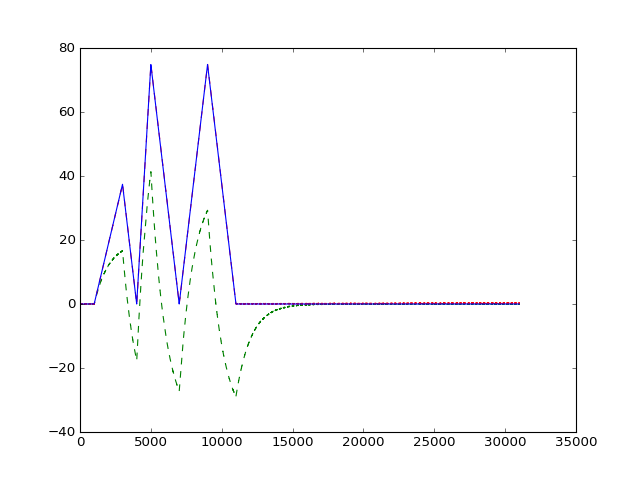

In [128]:
recons1 = BLRc(signal_daq=signal_out1,coef=freq_HPFd*np.pi,thr = 1*LSB)
# BLR reconstruction with pure algorithm
plt.figure(1)
plt.plot(range(0,np.size(signal_out1),1),signal_out1/LSB/SPE,'g--')
plt.plot(range(0,np.size(recons1),1),recons1/LSB/SPE,'r--', linewidth=1)
plt.plot(range(0,np.size(signal_in),1),GAIN*signal_in/LSB/SPE)
plt.show()

In [129]:
input_e = np.sum(GAIN*signal_in/LSB/SPE)
recons_e = np.sum(recons1[1000:11000]/LSB/SPE)
print 'Input SPE =', input_e
print 'Reconstructed SPE =', recons_e
print 'Error in SPE Computation (%) = ', (input_e-recons_e)/input_e*100

print 'Tail Noise =', np.std(recons1[25000:26000],ddof=1)/LSB
print 'Tail Mean =', np.mean(recons1[25000:26000])/LSB


Input Energy = 318001.02508
Reconstructed Energy = 318499.435844
Error in Energy Computation (%) =  -0.156732439622
Tail Noise = 0.82012242406
Tail Mean = 4.09344400903


## Tail Noise is coherent with expected value. Tail Mean is random and is related to the practical non-zero mean of the noise along the signal length

## ==================================================

## ==================================================

# EFFECT OF NOISE IN AC COUPLED FEE
## Noise is added after the AC filter as an equivalent input noise (FEE) which produces the lab measured noise at the output

In [130]:
speed_up=(signal.lfilter(b0,a0,signal_in))*(R1*Zin/(R1+Zin))

recons_a = np.zeros(2000)
for i in range(0,2000):
    noise = np.random.normal(0,0.18*LSB,31000)
    signal_hpf_b = speed_up + noise
    signal_out1_b = (signal.lfilter(b_LPF,a_LPF,signal_hpf_b))*A
    recons1 = BLRc(signal_daq=signal_out1_b,coef=freq_HPFd*np.pi,thr = 0.001)
    #print 'Tail Noise =', np.std(recons1[25000:26000],ddof=1)/LSB
    recons_a[i] = np.sum(recons1[1000:11000])


<IPython.core.display.Javascript object>


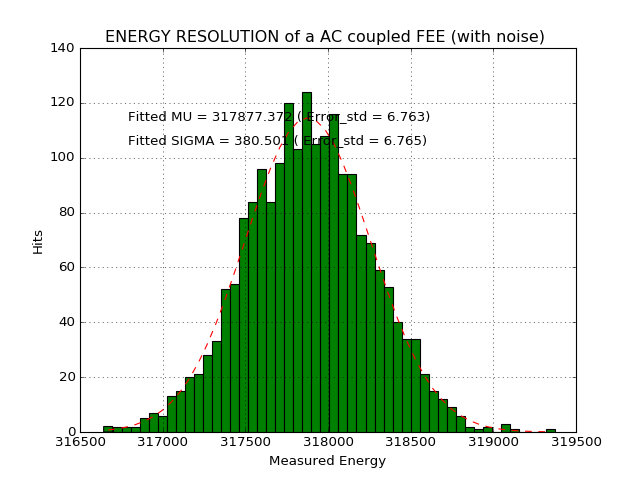

('Fitted A = ', 114.52149210018808, '( Error_std=', 1.7629686905491764, ')')
('Fitted MU = ', 317877.37153498421, '( Error_std=', 6.7633508808869065, ')')
('FItted SIGMA = ', 380.50129729778178, '( Error_std=', 6.7650024086272778, ')')
ENERGY RESOLUTION (%) =  0.281296540339


In [131]:
[coef,error]=fit.gauss1_fit(recons_a/LSB/SPE,'Measured SPE','Hits','ENERGY RESOLUTION of a AC coupled FEE (with noise) ',50,6,1)
print "ENERGY RESOLUTION (%) = ",(coef[2]/coef[1])*100*2.35

# EFFECT OF NOISE IN DC COUPLED FEE

In [132]:
recons_b = np.zeros(1000)
for i in range(0,1000):
    noise = np.random.normal(0,0.0031*LSB,31000)
    recons1b = signal_out1_b = (signal.lfilter(b_LPF,a_LPF,signal_in + noise))*GAIN
    #print 'Tail Noise =', np.std(recons1b[25000:26000],ddof=1)/LSB
    recons_b[i] = np.sum(recons1b[1000:11000])
  


<IPython.core.display.Javascript object>


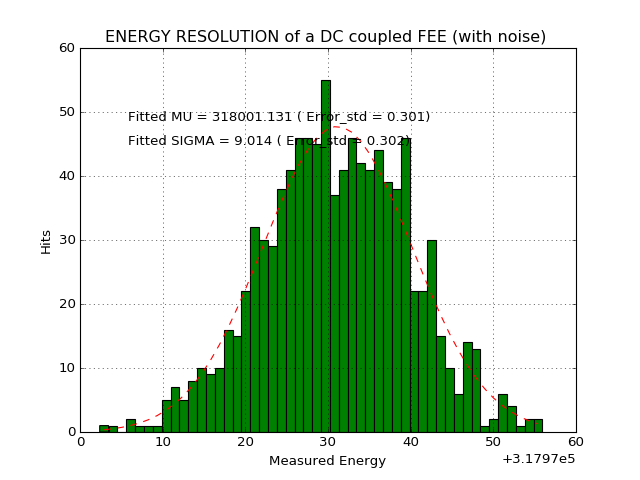

('Fitted A = ', 47.735389214107535, '( Error_std=', 1.3812590482137479, ')')
('Fitted MU = ', 318001.13066786685, '( Error_std=', 0.30102909092782992, ')')
('FItted SIGMA = ', 9.0143141159695244, '( Error_std=', 0.30197274764055609, ')')
ENERGY RESOLUTION (%) =  0.00666149775255


In [133]:
[coef2,error2]=fit.gauss1_fit(recons_b/LSB/SPE,'Measured SPE','Hits','ENERGY RESOLUTION of a DC coupled FEE (with noise) ',50,7,1)
print "ENERGY RESOLUTION (%) = ",(coef2[2]/coef2[1])*100*2.35